

# Casino HMM: Inference (state estimation)

We use a simple example of an HMM from known as the "occasionally dishonest casino".
This is from the book
"Biological Sequence Analysis: Probabilistic Models of Proteins and Nucleic Acids"
by R. Durbin, S. Eddy, A. Krogh and G. Mitchison (1998).



## Setup

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import matplotlib.pyplot as plt

from dynamax.hmm.models import CategoricalHMM

## Make model

![Casino HMM](https://github.com/probml/dynamax/blob/main/docs/figures/casino.png?raw=true)

In [3]:
init_dist = jnp.array([1, 1]) / 2
A = jnp.array([[0.95, 0.05], [0.10, 0.90]])
B = probs=jnp.array(
        [
            [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
            [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],  # loaded die
        ]
    )
print(B.shape)

(2, 6)


In [4]:
num_states = 2
num_emissions = 1 # 1d output
num_classes = 6 # size of output alphabet

hmm = CategoricalHMM(num_states, num_emissions, num_classes)

params = dict(
    initial=dict(probs=init_dist),
    transitions=dict(transition_matrix=A),
    emissions=dict(probs=B.reshape(num_states, num_emissions, num_classes))
    )


## Sample data from model

In [5]:
n_timesteps = 300
true_states, emissions = hmm.sample(params, jr.PRNGKey(42), n_timesteps)

print(true_states.shape)
print(emissions.shape)

(300,)
(300, 1)


In [6]:
# To sample multiple sequences, just use vmap
num_batches = 5
num_timesteps = 300

batch_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(0), num_batches))

print(batch_states.shape) # (5, 300)
print(batch_emissions.shape) # (5, 300, 1)

(5, 300)
(5, 300, 1)


In [7]:
def print_seq(true_states, emissions):
    T = 70
    to_string = lambda x: "".join(str(x + 1).split())
    print("hid: ", to_string(true_states[:T]))
    print("obs: ", to_string(emissions[:T, 0]))
    
print_seq(batch_states[0], batch_emissions[0])
print_seq(true_states, emissions)

hid:  [2222211111111111111111111111111112222222222111111111111111111111111112]
obs:  [6636644222425254541366534156435555311662663315351616222626113131426326]
hid:  [2222222221111111111111111111111122222222222222222222222222222111112221]
obs:  [6166665666644432314213244562342433654325363462364513646626146325646366]


In [8]:
# count fraction of times we see 6 in each state
obs = emissions + 1
hid = true_states + 1 
p0 = jnp.mean(obs[hid==1] == 6) # fair
p1 = jnp.mean(obs[hid==2] == 6) # loaded
print('empirical frequencies: ', jnp.array([p0, p1]))
print('expected frequencies: ', [1.0/6, 5.0/10])

empirical frequencies:  [0.14970061 0.46616542]
expected frequencies:  [0.16666666666666666, 0.5]


## Filtering (forwards algorithm)

In [9]:
posterior = hmm.filter(params, emissions)

print(posterior.marginal_loglik)
print(posterior.filtered_probs.shape)


-517.9524
(300, 2)


## Plotting code

In [10]:
import numpy as np

# Helper functions for plotting
def find_dishonest_intervals(states):
    """
    Find the span of timesteps that the
    simulated systems turns to be in state 1
    Parameters
    ----------
    states: array(n_timesteps)
        Result of running the system with two
        latent states
    Returns
    -------
    list of tuples with span of values
    """
    states = np.array(states)
    changepoints = np.concatenate([[0], np.nonzero(np.diff(states))[0] + 1, [len(states)]])
    starts, ends = changepoints[:-1], changepoints[1:]

    # Return the (start, end) pairs where the start state is 1
    dishonest = states[starts] == 1
    return list(zip(starts[dishonest], ends[dishonest]))


def plot_inference(inference_values, states, ax, state=1, map_estimate=False):
    """
    Plot the estimated smoothing/filtering/map of a sequence of hidden states.
    "Vertical gray bars denote times when the hidden
    state corresponded to state 1. Blue lines represent the
    posterior probability of being in that state given diﬀerent subsets
    of observed data." See Markov and Hidden Markov models section for more info
    Parameters
    ----------
    inference_values: array(n_timesteps, state_size)
        Result of running smoothing method
    states: array(n_timesteps)
        Latent simulation
    ax: matplotlib.axes
    state: int
        Decide which state to highlight
    map_estimate: bool
        Whether to plot steps (simple plot if False)
    """
    n_timesteps = len(inference_values)
    xspan = np.arange(1, n_timesteps + 1)
    spans = find_dishonest_intervals(states)
    if map_estimate:
        ax.step(xspan, inference_values, where="post")
    else:
        ax.plot(xspan, inference_values[:, state])

    for span in spans:
        ax.axvspan(*span, alpha=0.5, facecolor="tab:gray", edgecolor="none")
    ax.set_xlim(1, n_timesteps)
    # ax.set_ylim(0, 1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Observation number")

/var/folders/03/7y894xkj7k7266681pht1hw40000gn/T/ipykernel_56891/2597777607.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


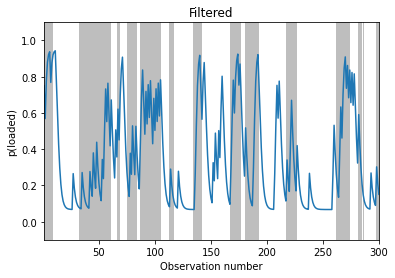

In [11]:
fig, ax = plt.subplots()
plot_inference(posterior.filtered_probs, true_states, ax)
ax.set_ylabel("p(loaded)")
ax.set_title("Filtered")
fig.show()
# pml.savefig("hmm_casino_filter")

## Smoothing (forwards-backwards algorithm)

In [12]:
posterior = hmm.smoother(params, emissions)

print(posterior.smoothed_probs.shape)

(300, 2)


In [ ]:
fig, ax = plt.subplots()
plot_inference(posterior.smoothed_probs, true_states, ax)
ax.set_ylabel("p(loaded)")
ax.set_title("Smoothed")
fig.show()
# pml.savefig("hmm_casino_smooth")

## MAP sequence (Viterbi algorithm)

In [14]:
most_likely_states = hmm.most_likely_states(params, emissions)

/var/folders/03/7y894xkj7k7266681pht1hw40000gn/T/ipykernel_56891/3940022341.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


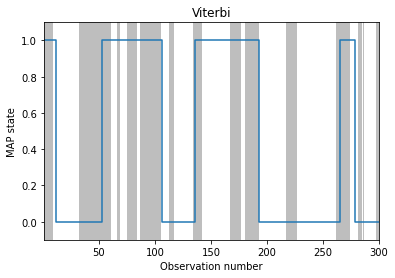

In [15]:
fig, ax = plt.subplots()
plot_inference(most_likely_states, true_states, ax, map_estimate=True)
ax.set_ylabel("MAP state")
ax.set_title("Viterbi")
fig.show()